In [1]:
import numpy as np
import pandas as pd
%pip install matplotlib
import matplotlib
matplotlib.use('Agg')  # necessary when matplotlib is imported
import matplotlib.pyplot as plt
%matplotlib inline

%pip install seaborn
import seaborn as sns
sns.set(style='whitegrid')

%pip install sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
plt.rcParams['figure.dpi'] = 100

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('Netflix Inc. (NFLX) Stock Price 2002-2025.csv', encoding='utf-8-sig')

# Clean column names by stripping any extra whitespace
df.columns = [col.strip() for col in df.columns]

# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert numeric columns from string to float (this will handle commas if present)
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_columns:
    # Remove any commas and extra spaces, then convert to numeric
    df[col] = pd.to_numeric(df[col].str.replace(',', '').str.strip(), errors='coerce')

# Quick check of the DataFrame structure
print('DataFrame loaded with shape:', df.shape)
print('Columns:', df.columns.tolist())

DataFrame loaded with shape: (5729, 7)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [3]:
print('Missing values per column:')
print(df.isnull().sum())

# Drop rows with missing Date or Close values (as these are critical)
df = df.dropna(subset=['Date', 'Close']).reset_index(drop=True)

# Sort data by Date
df = df.sort_values('Date')

# Create a new feature: number of days since the first observation
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

print('\nDataFrame shape after cleaning:', df.shape)

Missing values per column:
Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

DataFrame shape after cleaning: (5727, 8)


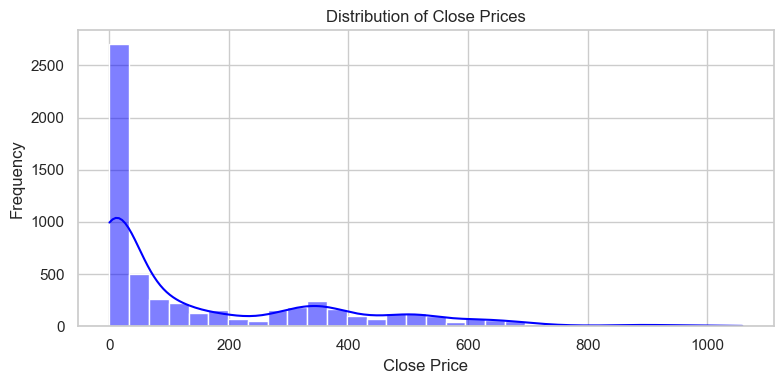

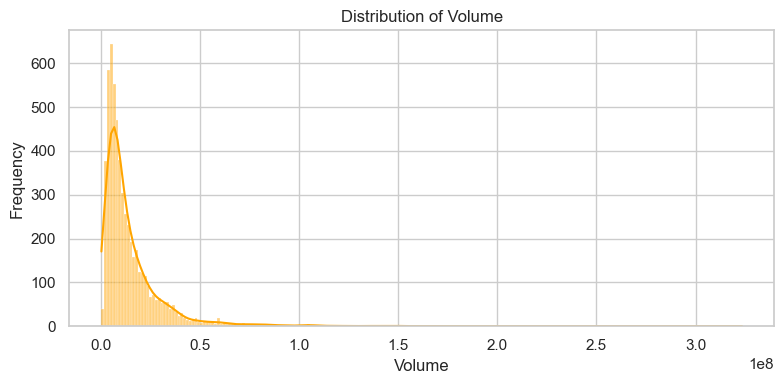

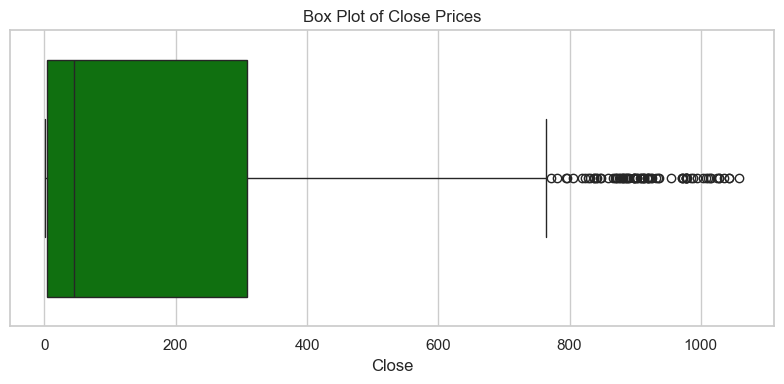

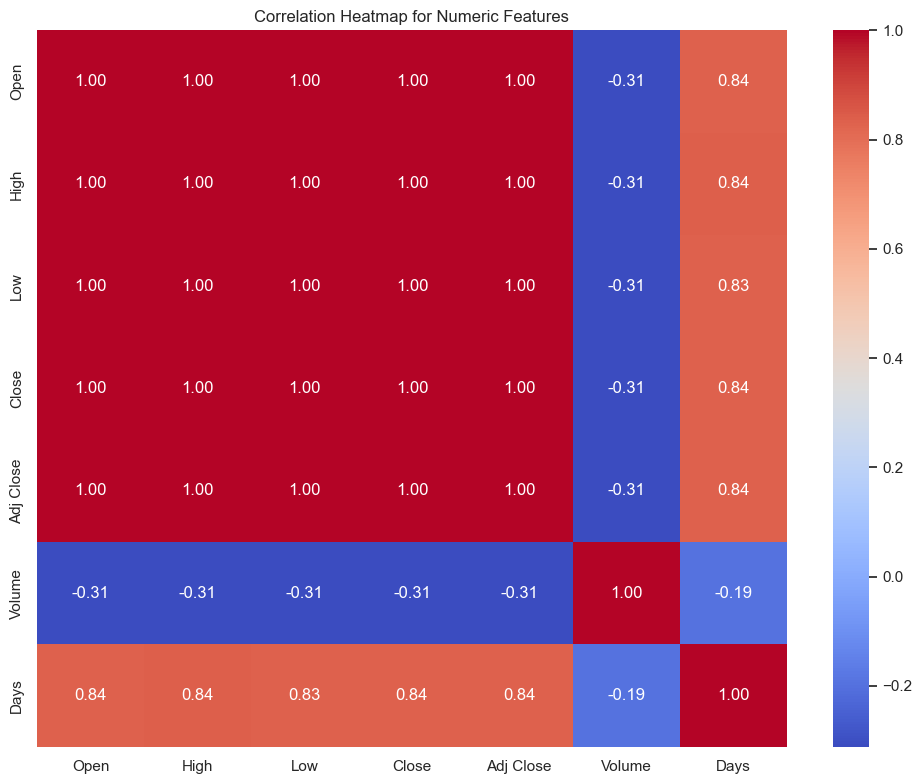

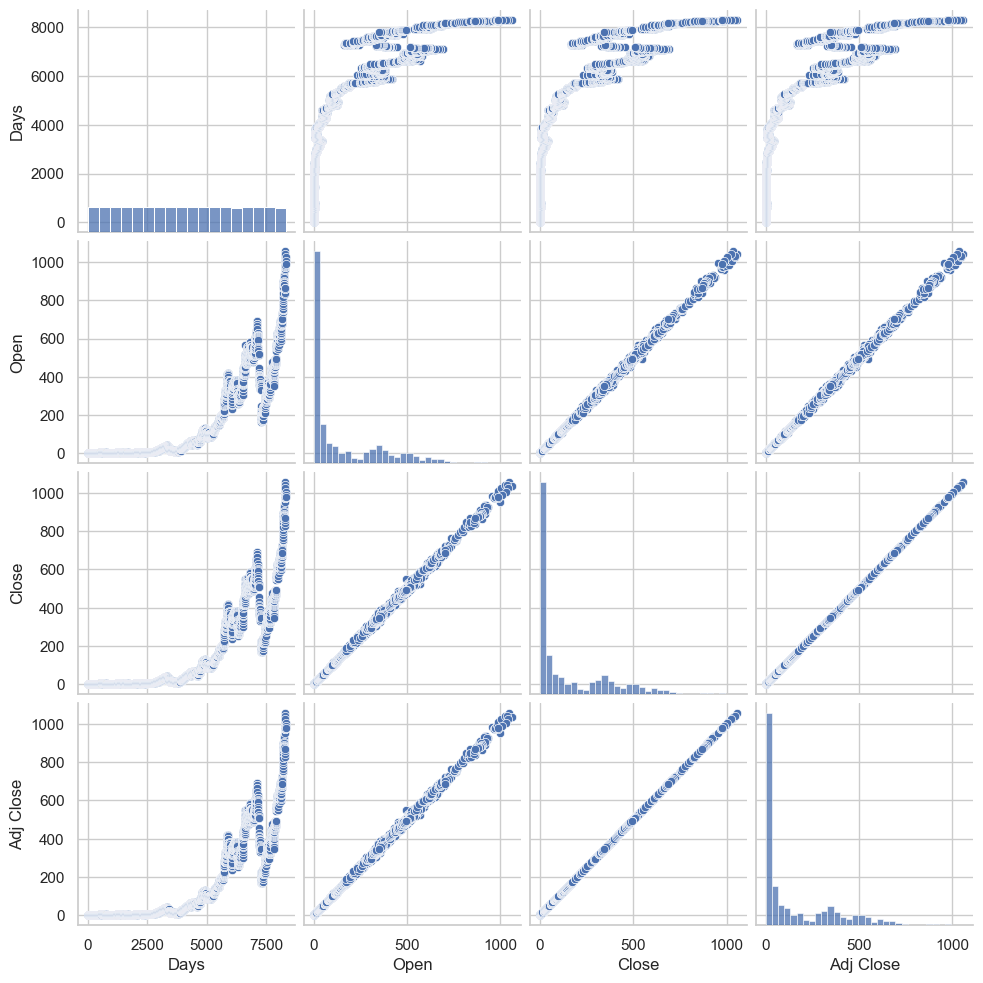

In [4]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Close'], kde=True, color='blue')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('hist_close.png')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['Volume'], kde=True, color='orange')
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('hist_volume.png')
plt.show()

# Box Plot to examine outliers in 'Close' prices
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Close'], color='green')
plt.title('Box Plot of Close Prices')
plt.tight_layout()
plt.savefig('boxplot_close.png')
plt.show()

# Create a correlation heatmap for numeric columns if there are four or more
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Numeric Features')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

# Pair Plot for key features
sns.pairplot(df[['Days', 'Open', 'Close', 'Adj Close']])
plt.savefig('pairplot.png')
plt.show()

In [5]:
df['Daily_Return'] = (df['Close'] - df['Open']) / df['Open']
df['5_MA'] = df['Close'].rolling(window=5).mean()
df['10_MA'] = df['Close'].rolling(window=10).mean()
df['Volatility'] = df['Close'].rolling(window=5).std()

# Drop NaN values caused by rolling window calculations
df.dropna(inplace=True)

# Create Target Variable (1 for Up, 0 for Down)
df['Price_Movement'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Select Features and Target
features = ['Open','Close', 'Daily_Return', '5_MA', '10_MA', 'Volatility']
X = df[features]
y = df['Price_Movement']

# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, shuffle=True)

# Train Naïve Bayes Model
model = GaussianNB()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

In [6]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.486013986013986
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.36      0.42       736
           1       0.48      0.62      0.54       694

    accuracy                           0.49      1430
   macro avg       0.49      0.49      0.48      1430
weighted avg       0.49      0.49      0.48      1430

Confusion Matrix:
 [[263 473]
 [262 432]]


In [7]:
df2 = pd.read_csv("netflix_titles_per_month.csv")
df2['date_added'] = pd.to_datetime(df2['date_added'],errors='coerce')

In [8]:
df2['year_month'] = df2['date_added'].dt.to_period('M')

titles_per_month = df2.groupby('year_month').size().reset_index(name='count')
titles_per_month['year_month'] = titles_per_month['year_month'].dt.to_timestamp()

In [9]:
# Convert 'averageRating' and 'numVotes' to numeric in case they're not already
df2['averageRating'] = pd.to_numeric(df2['averageRating'], errors='coerce')
df2['numVotes'] = pd.to_numeric(df2['numVotes'], errors='coerce')

# Filter for titles with average rating > 8.0 and numVotes >= 1000
high_rated_df = df2[(df2['averageRating'] > 8.0) & (df2['numVotes'] >= 1000)].copy()

# Group by month and count titles
high_rated_titles_per_month = (
    high_rated_df.groupby('year_month')
    .size()
    .reset_index(name='count')
)

# Convert year_month to datetime for consistency in plotting
high_rated_titles_per_month['year_month'] = high_rated_titles_per_month['year_month'].dt.to_timestamp()

# Preview result
high_rated_titles_per_month

,year_month,count
0,2011-10-01,1
1,2013-08-01,1
2,2014-11-01,1
3,2014-12-01,2
4,2015-02-01,1
...,...,...
71,2021-05-01,10
72,2021-06-01,11
73,2021-07-01,17
74,2021-08-01,10


In [10]:
# Sort by averageRating in descending order and display the top 10
top_20_highest_rated = high_rated_df.sort_values(by='averageRating', ascending=False).head(20)

# Display selected columns for clarity
top_20_highest_rated[['primaryTitle', 'averageRating', 'numVotes', 'date_added']]

,primaryTitle,averageRating,numVotes,date_added
851,Midnight Sun,9.8,78083,2021-07-08
2,Breaking Bad,9.5,2316546,2013-08-02
1240,God of War,9.5,41515,2017-12-16
4603,Jail,9.5,1621,2019-12-31
1733,We Need to Talk,9.5,20958,2016-09-01
1279,Blood Money,9.4,39175,2020-07-05
428,Planet Earth II,9.4,166103,2017-12-25
1110,Blue Planet II,9.3,51550,2018-12-03
3613,The Ultimatum,9.3,3558,2017-07-01
3151,Chosen,9.3,5029,2019-10-17


In [11]:
# Load and clean data
df = pd.read_csv('Netflix Inc. (NFLX) Stock Price 2002-2025.csv', encoding='utf-8-sig')
df.columns = [col.strip() for col in df.columns]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col].str.replace(',', '').str.strip(), errors='coerce')

df = df.dropna(subset=['Date', 'Close']).reset_index(drop=True)
df = df.sort_values('Date')
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

print('\nDataFrame shape after cleaning:', df.shape)

# --- Step 1: Resample to Monthly Data (first day of month) ---
df3 = df.set_index('Date').resample('MS').first().reset_index()

# --- Step 2: Filter data to include only before 2022 ---
df3 = df3[df3['Date'] < '2022-01-01'].copy()

# --- Step 3: Create Monthly_Price_Movement ---
df3['Prev_Close'] = df3['Close'].shift(1)
df3['Monthly_Price_Movement'] = (df3['Close'] > df3['Prev_Close']).astype(int)

# Drop the first row with NaN in Prev_Close
df3 = df3.dropna(subset=['Prev_Close']).reset_index(drop=True)

# Preview result
df3


DataFrame shape after cleaning: (5727, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Days,Prev_Close,Monthly_Price_Movement
0,2002-06-01,1.08,1.15,1.08,1.13,1.13,3151400.0,11,1.20,0
1,2002-07-01,1.00,1.05,0.99,1.03,1.03,4585000.0,39,1.13,0
2,2002-08-01,0.95,0.96,0.88,0.89,0.89,4529000.0,70,1.03,0
3,2002-09-01,0.94,0.96,0.91,0.93,0.93,1593200.0,103,0.89,1
4,2002-10-01,0.71,0.71,0.66,0.68,0.68,3850000.0,131,0.93,0
...,...,...,...,...,...,...,...,...,...,...
230,2021-08-01,519.00,519.85,510.51,515.15,515.15,2096600.0,7011,533.54,0
231,2021-09-01,569.00,591.00,569.00,582.07,582.07,5626200.0,7041,515.15,1
232,2021-10-01,604.24,614.99,597.51,613.15,613.15,4090800.0,7071,582.07,1
233,2021-11-01,689.06,689.97,676.54,681.17,681.17,3110900.0,7102,613.15,1


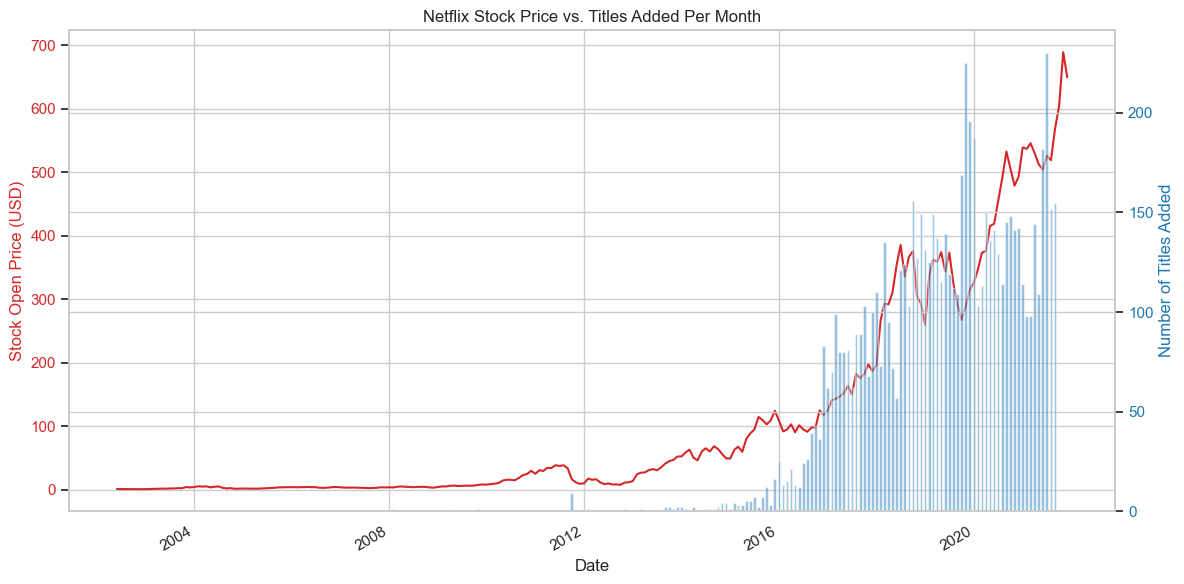

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for Netflix Open stock price
ax1.plot(df3['Date'], df3['Open'], color='tab:red', label='Open Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Open Price (USD)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_title('Netflix Stock Price vs. Titles Added Per Month')
ax1.grid(True)

# Twin axis for bar plot
ax2 = ax1.twinx()
ax2.bar(titles_per_month['year_month'], titles_per_month['count'], 
        width=20, alpha=0.5, color='tab:blue', label='Titles Added')
ax2.set_ylabel('Number of Titles Added', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Rotate x-axis labels
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

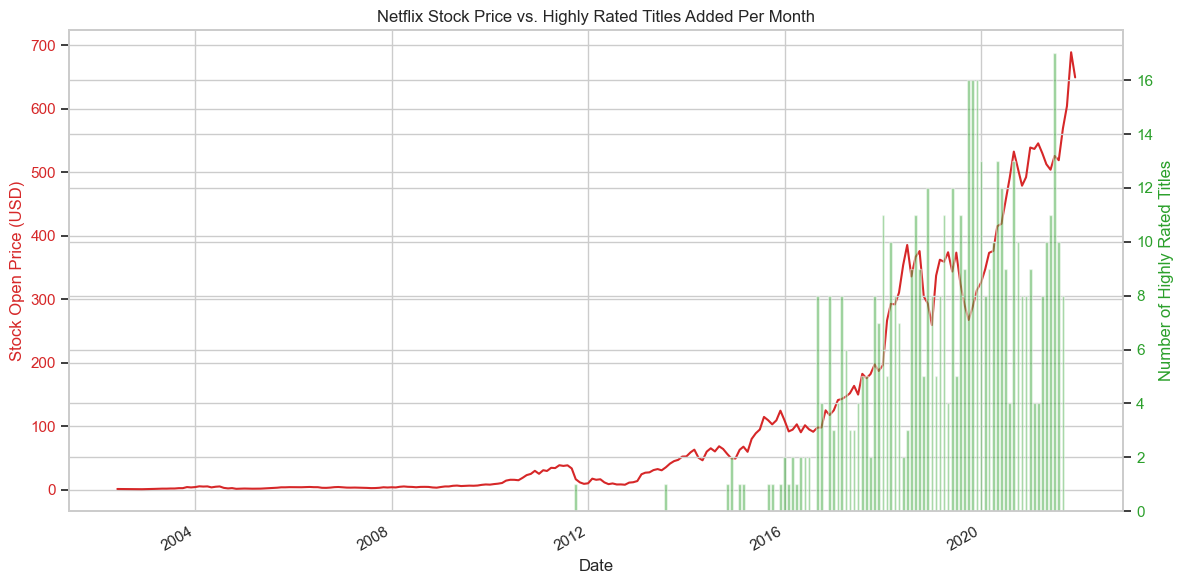

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for Netflix Open stock price
ax1.plot(df3['Date'], df3['Open'], color='tab:red', label='Open Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Open Price (USD)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_title('Netflix Stock Price vs. Highly Rated Titles Added Per Month')
ax1.grid(True)

# Twin axis for bar plot of high-rated titles
ax2 = ax1.twinx()
ax2.bar(high_rated_titles_per_month['year_month'], high_rated_titles_per_month['count'], 
        width=20, alpha=0.5, color='tab:green', label='Highly Rated Titles Added')
ax2.set_ylabel('Number of Highly Rated Titles', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Rotate x-axis labels
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [14]:
# --- Merge df3 with high_rated_titles_per_month on Date ---
# Rename column for clarity and matching
high_rated_titles_per_month = high_rated_titles_per_month.rename(columns={'year_month': 'Date', 'count': 'High_Rated_Titles_Added'})

# Merge on 'Date'
merged_df = pd.merge(df3, high_rated_titles_per_month, on='Date', how='left')

# Fill missing months (with no high-rated titles) with 0
merged_df['High_Rated_Titles_Added'] = merged_df['High_Rated_Titles_Added'].fillna(0)

# Add a new column 'High_Rated_Titles_Added_Last_Month' by shifting the 'High_Rated_Titles_Added' column by 1
merged_df['High_Rated_Titles_Added_Last_Month'] = merged_df['High_Rated_Titles_Added'].shift(1)

# Fill NaN values (from the first month) with 0 (no high-rated titles added in the first month)
merged_df['High_Rated_Titles_Added_Last_Month'] = merged_df['High_Rated_Titles_Added_Last_Month'].fillna(0)

merged_df['High_Rated_Titles_Added_Last_Three_Months'] = merged_df['High_Rated_Titles_Added'].shift(3)
merged_df['High_Rated_Titles_Added_Last_Three_Months'] = merged_df['High_Rated_Titles_Added_Last_Three_Months'].fillna(0)

# Optional preview
merged_df

,Date,Open,High,Low,Close,Adj Close,Volume,Days,Prev_Close,Monthly_Price_Movement,High_Rated_Titles_Added,High_Rated_Titles_Added_Last_Month,High_Rated_Titles_Added_Last_Three_Months
0,2002-06-01,1.08,1.15,1.08,1.13,1.13,3151400.0,11,1.20,0,0.0,0.0,0.0
1,2002-07-01,1.00,1.05,0.99,1.03,1.03,4585000.0,39,1.13,0,0.0,0.0,0.0
2,2002-08-01,0.95,0.96,0.88,0.89,0.89,4529000.0,70,1.03,0,0.0,0.0,0.0
3,2002-09-01,0.94,0.96,0.91,0.93,0.93,1593200.0,103,0.89,1,0.0,0.0,0.0
4,2002-10-01,0.71,0.71,0.66,0.68,0.68,3850000.0,131,0.93,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2021-08-01,519.00,519.85,510.51,515.15,515.15,2096600.0,7011,533.54,0,10.0,17.0,10.0
231,2021-09-01,569.00,591.00,569.00,582.07,582.07,5626200.0,7041,515.15,1,8.0,10.0,11.0
232,2021-10-01,604.24,614.99,597.51,613.15,613.15,4090800.0,7071,582.07,1,0.0,8.0,17.0
233,2021-11-01,689.06,689.97,676.54,681.17,681.17,3110900.0,7102,613.15,1,0.0,0.0,10.0


Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best parameters: {'C': np.float64(10000.0), 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.927741935483871

Test Accuracy: 0.963855421686747
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        37
           1       0.94      1.00      0.97        46

    accuracy                           0.96        83
   macro avg       0.97      0.96      0.96        83
weighted avg       0.97      0.96      0.96        83



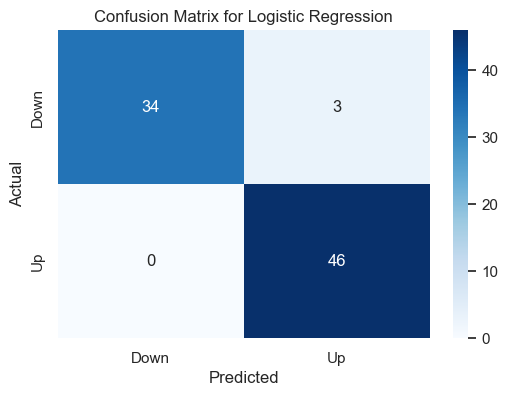

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Load your dataset (replace with your actual dataframe)
# df = pd.read_csv("your_dataset.csv")

# Example: Define features and target (replace with your actual features/target columns)
X = merged_df[['Open', 'Close', 'Prev_Close', 'Volume', 'High_Rated_Titles_Added_Last_Month']]  # Replace with your actual feature columns
y = merged_df['Monthly_Price_Movement']  # Replace with your actual target column

# --- Split data into training and test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

# --- Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Logistic Regression Model ---
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# --- Hyperparameter tuning using GridSearchCV ---
# Define the hyperparameters to search
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength (inverse)
    'penalty': ['l2'],            # L2 penalty (you can also try 'l1')
    'solver': ['lbfgs', 'liblinear']  # Solvers to consider
}

# Perform grid search with cross-validation
k = 5
grid_search = GridSearchCV(model, param_grid, cv=k, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score from grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# --- Fit the best model on the entire training data ---
best_model = grid_search.best_estimator_

# --- Evaluate model on test set ---
y_pred_test = best_model.predict(X_test_scaled)

# --- Performance Metrics ---
print(f'\nTest Accuracy: {accuracy_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [16]:
from sklearn.model_selection import StratifiedKFold

# Initialize the best model from GridSearch
best_model = grid_search.best_estimator_

# Repeated cross-validation for variance analysis
n_repeats = 500
k = 5
accuracies = []

for i in range(n_repeats):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=i)
    scores = cross_val_score(best_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    accuracies.extend(scores)
    #print(f"Repeat {i+1}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

# Convert to NumPy array for analysis
accuracies = np.array(accuracies)

# Overall stats
print(f"\nOverall Cross-Validation Accuracy (over {n_repeats}x{k} folds):")
print(f"Mean Accuracy: {accuracies.mean():.4f}")
print(f"Standard Deviation: {accuracies.std():.4f}")
print(f"Min Accuracy: {accuracies.min():.4f}")
print(f"Max Accuracy: {accuracies.max():.4f}")


Overall Cross-Validation Accuracy (over 500x5 folds):
Mean Accuracy: 0.9055
Standard Deviation: 0.0518
Min Accuracy: 0.7000
Max Accuracy: 1.0000


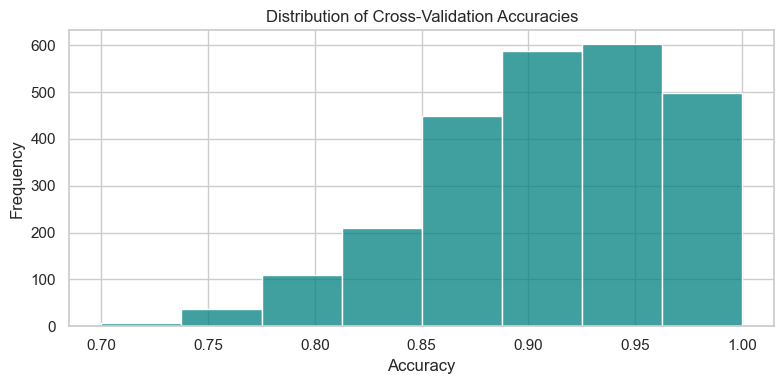

In [18]:
# --- Accuracy Distribution Plot ---
plt.figure(figsize=(8, 4))
sns.histplot(accuracies, bins=8, kde=False, color='teal')
plt.title('Distribution of Cross-Validation Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()